# PART 2 - Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

In [1]:
from IPython.core.display import display, HTML

import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
import scikitplot as skplt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut

#function to plot grid
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42


SEED = 1234
seed(SEED)
np.random.seed(SEED)

df = pd.read_csv('compas-scores-two-years.csv')
# df.head()

In [2]:
# preparing data by selecting needed colums and removing empty values
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
#df = df.dropna(how='any')
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


next we need to convert string data into values/ numbers to be able to use it to train, test and predict

In [3]:
#converting to values
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


#### splitting dataset and choosing ground truth

Next step is to divide our dataset. we cannot use the same data trained for testing so we divide the data into train and test set. we will use 0.2 percent of the training dataset as the validation set. We then need to convert them into a tensor(a set of data/ information relating to one person as relating to COMPAS) to be able to train and test with Pytorch

In [4]:
#splitting and converting data to tensor
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([5771, 10]) torch.Size([5771])
torch.Size([1443, 10]) torch.Size([1443])


### Building the network
From the shape above, our input data contains 10 columns which also means our input feature is 10. Network input also has to match up to this number.
Our network will also have two hidden layers of 5 and 3 nodes respectively

#### First Model

In [5]:
# Defining the model
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [6]:
# ann_viz(net, view=False)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)
# net = net.to(device)
# criterion = criterion.to(device)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1200):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

# Save model
MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

epoch 0
Train set - loss: 0.668, accuracy: 0.632
Test  set - loss: 0.664, accuracy: 0.666

epoch 400
Train set - loss: 0.304, accuracy: 0.908
Test  set - loss: 0.291, accuracy: 0.912

epoch 800
Train set - loss: 0.281, accuracy: 0.906
Test  set - loss: 0.263, accuracy: 0.91



/home/marck-edward/miniconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
# Test the model using test set
net = torch.load(MODEL_PATH)
classes = ['No Recid', 'Recid']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.95      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9106029106029107


Our model produces a higher overall accuracy of 0.91 as compared to the compass model of 0.65 

### Predicting Recidivism(tendency to reoffend) based on first model
Definitions and possible parameters.
We would like to analyse some possible attributes that account for the risk of recidivism. Prior_count, race and decile scores.

some sample Predictions follow below.

In [8]:
def will_recid(sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event):
  t = torch.as_tensor([sex,age_cat, race, juv_fel_count, juv_misd_count, priors_count, c_charge_degree, is_violent_recid, v_decile_score, event]) \
      .float()
  output = net(t)
  return output.ge(0.5).item()

# Possible values
print("sex : " + str(df.sex.unique()))
print("race : " + str(df.race.unique()))
print("age_cat : " + str(df.age_cat.unique()))
print("juv_fel_count : " + str(df.juv_fel_count.unique()))
print("juv_misd_count : " + str(df.juv_misd_count.unique()))
print("priors_count : " + str(df.priors_count.unique()))
print("c_charge_degree : " + str(df.c_charge_degree.unique()))
print("is_violent_recid : " + str(df.is_violent_recid.unique()))
print("v_decile_score : " + str(df.v_decile_score.unique()))
print("event : " + str(df.event.unique()))

sex : [1 2]
race : [1 2 3 4 5 6]
age_cat : [1 2 3]
juv_fel_count : [ 0  2  1  8  4  3  9 20  6  5 10]
juv_misd_count : [ 0  1  6 12  2  4  3  8  5 13]
priors_count : [ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
c_charge_degree : [1 2]
is_violent_recid : [0 1]
v_decile_score : [ 1  3  6  2  5  4  9  7 10  8]
event : [0 1]



We want to determine if our model work like Propublica (same, better or worse) by predicting few instances.

In [9]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=6, priors_count =14, 
           c_charge_degree =1, is_violent_recid =1, v_decile_score =1, event= 0)

True

In [10]:
will_recid(sex=2, race= 5, age_cat=3, juv_fel_count=1, juv_misd_count=0, priors_count =1, 
           c_charge_degree =7, is_violent_recid =0, v_decile_score =3, event= 0)

False

In [11]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=0, juv_misd_count=1, priors_count =0, 
           c_charge_degree =1, is_violent_recid =0, v_decile_score =1, event= 0)

False

In [12]:
will_recid(sex=1, race= 2, age_cat=1, juv_fel_count=2, juv_misd_count=0, priors_count =0, c_charge_degree =1, 
           is_violent_recid =0, v_decile_score =4, event= 0)

False

In [13]:
will_recid(sex=1, race= 5, age_cat=2, juv_fel_count=0, juv_misd_count=2, priors_count =2, c_charge_degree =0, 
           is_violent_recid =1, v_decile_score =3, event= 0)

True

#### Second Model
For subsequent model, we would like to used a validation set. From the dataset, we use 20% of it as the test set and he rest is used for training. We then use 10% of the training set for the validation set.

<ul>Notes
<li>two_year_recid is not possibility. Its the ground truth. What we are trying to do there is to show the ground truth is relatively balanced</li>
<li>we could split two times the data, until we have separate: training, testing, and validation set.</li>
<li>Maybe its okay to show the figure of the architecture.
<li>What is the v_decile_graph for?</li>
<li>We can compare by making predictions of some rows in the dataset where the compas classifier failed. For intance maybe there are some rows where score_text is 'High' and decile_score is '10' however the criminals didn't recid (two_year_recid = 0)</li>    
</ul>

In [14]:
# Arrange the data : Training, Testing, Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# conversion to tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_test.shape) +", "+ str(y_test.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))


Training	 :torch.Size([5193, 10]), torch.Size([5193])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([578, 10]), torch.Size([578])


#### Using Mean Squared Error(MSE)
MSE is the default loss function to be used in a regression problem. this is also used when the data is not seperable or for estimation purposes.
obviously, this will not perform well on this classification but none the less, we want to see why and how it performs on classification problems.
MSE measures the average squared difference between the estimated values and the actual values.
With MSE, it is a requirement that the output layer has just one node and also he linear activation function is used in this respect

In [16]:
#try using different loss function #2
criterion = torch.nn.MSELoss(reduction='sum')

#using a nn module from pytorch
secondmodel = nn.Sequential(
    nn.Linear(10, 12),
    nn.ReLU(),
    nn.Linear(12, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
#     nn.Sigmoid()
)
print(secondmodel)
print("\n")

optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1200):
    y_pred = secondmodel(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = secondmodel(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = secondmodel(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

Sequential(
  (0): Linear(in_features=10, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 5555.59, accuracy: 0.544
            Validation set	 - loss: 617.45, accuracy: 0.547
            
epoch 400
            Train set		 - loss: 5555.59, accuracy: 0.544
            Validation set	 - loss: 617.45, accuracy: 0.547
            
epoch 800
            Train set		 - loss: 5555.59, accuracy: 0.544
            Validation set	 - loss: 617.45, accuracy: 0.547
            
              precision    recall  f1-score   support

    No Recid       0.57      1.00      0.73       823
       Recid       0.00      0.00      0.00       620

    accuracy                           0.57      1443
   macro avg       0.29      0.50      0.36      1443
weighted avg       0.33      0.57      0.41      1443

Overall Accuracy :  0.5703395703395704


/home/marck-edward/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see the model performed poorly using MSE as the loss function. overall accuracy is at 0.64 which is not good to use for predicting if a criminal will recidiviate or not. The accuracy is almost the same as the compass accuacy standing at 0.653.

#### Third Model
for this model, we would want to see the performance when using tanh activation functions which is non linear.

In [19]:
# Using different activation functions : from relu -> tanh
class thirdmodel(nn.Module):

  def __init__(self, n_features):
    super(thirdmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = thirdmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

thirdmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1323.311, accuracy: 0.544
            Validation set	 - loss: 145.786, accuracy: 0.547
            
epoch 400
            Train set		 - loss: 446.038, accuracy: 0.908
            Validation set	 - loss: 54.291, accuracy: 0.896
            
epoch 800
            Train set		 - loss: 389.347, accuracy: 0.909
            Validation set	 - loss: 47.758, accuracy: 0.9
            
epoch 1200
            Train set		 - loss: 381.906, accuracy: 0.91
            Validation set	 - loss: 46.577, accuracy: 0.905
            
epoch 1600
            Train set		 - loss: 378.966, accuracy: 0.911
            Validation set	 - loss: 46.157, accuracy: 0.903
            
              precision    recall  f1-score   support

    No Recid       0.90      0.96      0.93       823
 

Our third model performs almost same as our first model which had an accuracy of 0.912 and obviously better than the accuracy of compas.
### fourth model
we build a fourth model by adding more layers to model 2 and more neurons to the hidden layers. Neurons on the input layers has to remain same to fit the shape of the dataset.

In [20]:
# Defining the model  #4
# Adding layers and neurons
class fourthmodel(nn.Module):

  def __init__(self, n_features):
    super(fourthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = F.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = fourthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(3200):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

fourthmodel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1328.218, accuracy: 0.396
            Validation set	 - loss: 147.139, accuracy: 0.424
            
epoch 400
            Train set		 - loss: 372.963, accuracy: 0.913
            Validation set	 - loss: 45.456, accuracy: 0.901
            
epoch 800
            Train set		 - loss: 358.106, accuracy: 0.918
            Validation set	 - loss: 46.064, accuracy: 0.903
            
epoch 1200
            Train set		 - loss: 347.561, accuracy: 0.922
            Validation set	 - loss: 46.417, accuracy: 0.901
            
epoch 1600
            Train set		 - loss: 338.859, accuracy: 0.925
            Validation set	 - loss: 47.398, accuracy: 0.898
            
epoch 2000
            Train set		 - loss:

We observed that the accuracy reduced a little by 0.012 as compared to the original third model. We can say that trying to increase the accuracy of the classifier does not have to do with only adding more layers and neurons to the network. We can also observe overfitting starting at epoch 2400.
### Fifth model
still use the second model but with relu as the activation function

fifthmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch 0
            Train set		 - loss: 1293.594, accuracy: 0.544
            Validation set	 - loss: 144.135, accuracy: 0.547
            
epoch 400
            Train set		 - loss: 436.702, accuracy: 0.909
            Validation set	 - loss: 53.782, accuracy: 0.898
            
epoch 800
            Train set		 - loss: 386.635, accuracy: 0.909
            Validation set	 - loss: 48.222, accuracy: 0.898
            
epoch 1200
            Train set		 - loss: 383.616, accuracy: 0.909
            Validation set	 - loss: 47.868, accuracy: 0.898
            
epoch 1600
            Train set		 - loss: 382.605, accuracy: 0.909
            Validation set	 - loss: 47.789, accuracy: 0.9
            
              precision    recall  f1-score   support

    No Recid       0.89      0.96      0.93       823


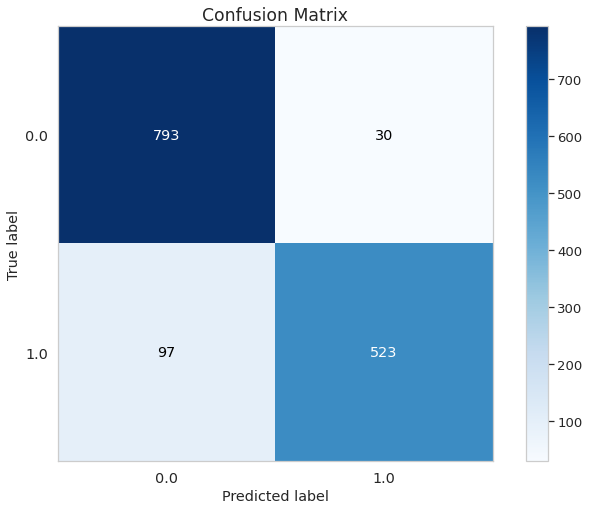

In [23]:
# Defining the model #5
# Using custom module
class fifthmodel(nn.Module):

  def __init__(self, n_features):
    super(fifthmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = fifthmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
for epoch in range(2000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 400 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_validate_pred = net(X_validate)
      y_validate_pred = torch.squeeze(y_validate_pred)
      validate_loss = criterion(y_validate_pred, y_validate)
      validation_acc = calculate_accuracy(y_validate, y_validate_pred)
      print(
            f'''epoch {epoch}
            Train set\t\t - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Validation set\t - loss: {round_tensor(validate_loss)}, accuracy: {round_tensor(validation_acc)}
            ''')
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

an overall accuracy of 0.913 almost same as using tanh as the activation function.

We can see so far that most of our classifiers are doing well. TThis means that moset cases are clasified correctly. Recall, precision and accuracy is almost at a score of 1 which is a good sign.

From the confusion matrix, we can see a greater portion of the data was correctly classified from the prediction. there is a higher number of True Positives as compared to the compass prediction in the first part.

Below is a graph showing the difference between the overall accuracies of the five models.

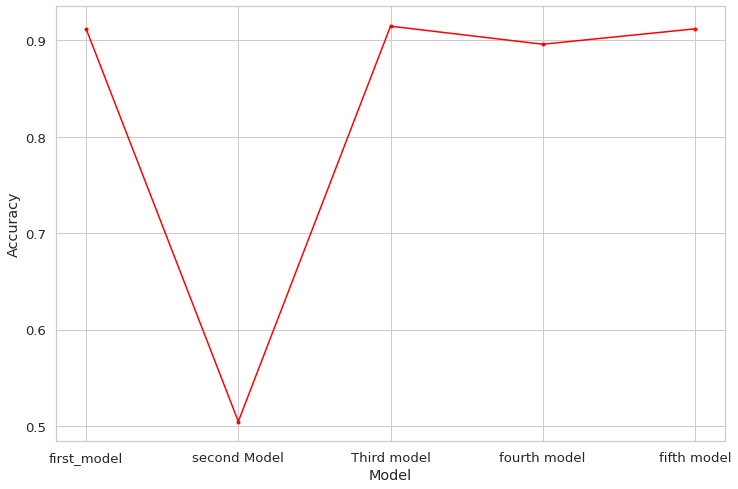

In [21]:
#accuracy graph between models
Accuracy = [0.911988911988912, 0.5045045045045045, 0.9147609147609148, 0.896049896049896, 0.911988911988912]
Model = ['first_model', 'second Model', 'Third model', 'fourth model', 'fifth model']
plt.plot(Model, Accuracy, marker='.', color="red")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

We can see tha model 1, 3 and 5 performs almost the same.

### Predictions based on fifthmodel

we want to define a new dataset to use for prediction and observe fairness. We will use criminals labelled with the various risk score/decile score but having a two_year_recid or for this analysis.


In [24]:
df2 = pd.read_csv('compas-scores-two-years.csv')

df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

#no two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==0) & (df2['score_text']=='High')]
# print ('shape of filtered data is ', df2.shape)

df3 = df2[df.columns[~df.isnull().any()]]
df3 = df3[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]

print ('shape of data is ', df3.shape)

#prediction
X_pred = torch.from_numpy(df3.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)


shape of data is  (402, 10)
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True,  True, False,  True, False, False, False, False,
         True, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False,  True, False,  True,  True, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False,  True, False,  True,  True,
        False, False, False, False,  True, False, False, False, False, False,
         True, False, False, False, False,  True, False, False,  True, False,
         True,  True, False,  True, 

In [27]:
df2 = pd.read_csv('compas-scores-two-years.csv')

df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

#no two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==1) & (df2['score_text']=='High')]
# print ('shape of filtered data is ', df2.shape)

df3 = df2[df.columns[~df.isnull().any()]]
df3 = df3[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]

print ('shape of data is ', df3.shape)

#prediction
X_pred = torch.from_numpy(df3.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)


shape of data is  (1001, 10)
tensor([True, True, True,  ..., True, True, True])


In [56]:
df2 = pd.read_csv('compas-scores-two-years.csv')

#two_year _recid with Low label
df2 = df2.loc[(df2['two_year_recid']==1) & (df2['score_text']=='Low')]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
df2 = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]
df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

print ('shape of is ', df2.shape)
X_pred = torch.from_numpy(df2.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)

shape of is  (1216, 10)
tensor([ True, False,  True,  ...,  True,  True, False])


In [186]:
df2 = pd.read_csv('compas-scores-two-years.csv')

#two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==1) & (df2['score_text']=='High')]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
df2 = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]
df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

print ('shape of is ', df2.shape)
X_pred = torch.from_numpy(df2.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)

shape of is  (1001, 10)
tensor([True, True, True,  ..., True, True, True])


In [42]:
df2 = pd.read_csv('compas-scores-two-years.csv')

#no two_year _recid with Medium label
df2 = df2.loc[(df2['two_year_recid']==0) & (df2['score_text']=='Medium')]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
df2 = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]
df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

print ('shape of is ', df2.shape)
X_pred = torch.from_numpy(df2.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)

shape of is  (880, 10)
tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False

In [205]:
df2 = pd.read_csv('compas-scores-two-years.csv')

#no two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==0) & (df2['score_text']=='High')]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
df2 = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]
df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

print ('shape of is ', df2.shape)
X_pred = torch.from_numpy(df2.to_numpy()).float()
X_pred = net(X_pred)
X_pred = X_pred.ge(.5).view(-1).cpu()
print (X_pred)

shape of is  (402, 10)
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False,  True, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True, False, False, False, False,  True, False, False,
         True,  True,  True, False, False, False, False,  True, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False,  True,  True, False, False

## todo - define fairness
## represent output of predictions to explain